## Vertex reconstruction in a large Directional Liquid Scintillator Detector
Training data location: https://stash.osgconnect.net/public/elagin/vtx_dir_1el_norm/

Testing data location: https://stash.osgconnect.net/public/elagin/test_vtx_dir_1el_norm/

Data are .npz files with 3 numpy arrays. Where each row correspond to one event.

"x" is a (1000,6300) array of "independent variables", photo-electron hits (theta, phi, and time). Hit coordinate encoding in each row is the folowing: \
theta = x[:,0::3] \
phi = x[:,1::3] \
time = x[:,2::3] \
All data is normalized as theta = theta/pi, phi = phi/(2pi), time = time/maxT (currently maxT=150). \
Each row in "x" is padded with -1 to make it a length of 6300 

"y_vtx" is a (1000,3) array of "dependent variable", true x-,y-,z- coordinates of the event vertex to be reconstructed \
"y_dir" is a (1000,3) array of "dependent variable", true x-,y-,z- coordinates of the unit vector along the original direction of the electron

See checking_inputs.ipynb and checking_inputs_norm.ipynb for more details on the data

In [1]:
import os
import math

import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import random

In [2]:

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda, Input, Concatenate, concatenate
from keras.layers import Conv1D, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling1D, MaxPooling2D, LocallyConnected2D, LocallyConnected1D
from keras.layers import LSTM, Bidirectional
from keras.layers import Masking
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
import keras.backend as K

In [3]:
#global variables
maxT = 37
maxLambda = 800
PAD_VALUE = -1
NEvts = 1000
pi = 3.141592653589793
NFiles = 100

### Custom generator to load large datasets

In [4]:
from keras.utils import Sequence
from keras.preprocessing.sequence import pad_sequences

class MyGenerator(Sequence):
    def __init__(self, x_dir, batch_size):
        self.x_dir = x_dir
        self.x = os.listdir(x_dir)
        self.batch_size = batch_size
        print('Generator init complete')
        
    def __len__(self):
        nf = self.batch_size/(NEvts) # calculate number of files
        return math.ceil(len(self.x) / nf)

    def __getitem__(self, idx):
        batch_data = np.load(os.path.join(self.x_dir, self.x[idx]))
        Y = np.array(batch_data['y_vtx'])
        return np.array(batch_data['x']), Y

In [5]:
training_generator = MyGenerator('/data/Elagin/vtxT_dir_1el_norm', NEvts)

#testing_generator = MyGenerator('/data/Elagin/test_vtx_dir_1el_color_norm', NEvts)

Generator init complete


### Loading data that can fit into RAM

In [6]:
# Load data from x_dir, stop after loading fn_max files
# Returns X, Y, Dir
# X - independent variables
# Y - dependend variables (x-, y-, z- of the vertex in this implementation)
# Dir - direction vector (x-, y-, z- componenets), could be made dependent variable
def load_test_data_to_memory(x_dir, fn_max=2000) :
    X, Y, Dir = np.array([]), np.array([]), np.array([])
    f_list = os.listdir(x_dir)
    f_list.sort()
    i=0
    for x in f_list :
        batch_data = np.load(os.path.join(x_dir, x))
        
        X = np.vstack([X, np.array(batch_data['x'])]) if X.size else np.array(batch_data['x'])
        Y = np.vstack([Y, np.array(batch_data['y_vtx'])]) if Y.size else np.array(batch_data['y_vtx'])
        Dir = np.vstack([Dir, np.array(batch_data['y_dir'])]) if Dir.size else np.array(batch_data['y_dir'])

        i+=1
        if i%10 == 0:
            print(x)
            print('i = ', i, '   ', X.shape, '   ', Y.shape, '   ', Dir.shape)
        if i>=fn_max:
            break
    print(X.shape, '   ', Y.shape, '   ', Dir.shape)
    return X, Y, Dir

In [7]:
testX, testY, trueDir = load_test_data_to_memory('/data/Elagin/test_vtxT_dir_1el_norm/')

f_batch_1408.npz
i =  10     (10000, 6300)     (10000, 4)     (10000, 3)
f_batch_1418.npz
i =  20     (20000, 6300)     (20000, 4)     (20000, 3)
(29000, 6300)     (29000, 4)     (29000, 3)


In [6]:
trainX, trainY, trueDir_training = load_test_data_to_memory('/data/Elagin/vtxT_dir_1el_norm/',200)

f_batch_108.npz
i =  10     (10000, 6300)     (10000, 4)     (10000, 3)
f_batch_117.npz
i =  20     (20000, 6300)     (20000, 4)     (20000, 3)
f_batch_126.npz
i =  30     (30000, 6300)     (30000, 4)     (30000, 3)
f_batch_135.npz
i =  40     (40000, 6300)     (40000, 4)     (40000, 3)
f_batch_144.npz
i =  50     (50000, 6300)     (50000, 4)     (50000, 3)
f_batch_153.npz
i =  60     (60000, 6300)     (60000, 4)     (60000, 3)
f_batch_162.npz
i =  70     (70000, 6300)     (70000, 4)     (70000, 3)
f_batch_171.npz
i =  80     (80000, 6300)     (80000, 4)     (80000, 3)
f_batch_180.npz
i =  90     (90000, 6300)     (90000, 4)     (90000, 3)
f_batch_19.npz
i =  100     (100000, 6300)     (100000, 4)     (100000, 3)
f_batch_199.npz
i =  110     (110000, 6300)     (110000, 4)     (110000, 3)
f_batch_29.npz
i =  120     (120000, 6300)     (120000, 4)     (120000, 3)
f_batch_39.npz
i =  130     (130000, 6300)     (130000, 4)     (130000, 3)
f_batch_49.npz
i =  140     (140000, 6300)     (140

### Defining various activation functions

In [8]:
def mapping_to_pmOne(x) :
    return 2*K.sigmoid(x) - 1

def mapping_to_pm50(x) :
    return mapping_to_pmOne(x)*50

def mapping_to_pm300(x) :
    return mapping_to_pmOne(x)*300

def mapping_to_0_50(x) :
    return 50*K.sigmoid(x)


def mapping_to_target_range_all( x, target_min=-0.02*pi, target_max=2.02*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

def mapping_to_target_range_2pi( x, target_min=-0.00*pi, target_max=2.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_pi( x, target_min=-0.00*pi, target_max=1.00*pi ) :
    x02 = K.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min
    #return K.sigmoid(x)*target_max

def mapping_to_target_range_phi( x, target_min=0, target_max=2*pi ) :
    print('is x keras tensor:', K.is_keras_tensor(x))
    print('x shape = ',K.int_shape(x))
    print('x shape = ',K.shape(x))
    #phi = K.placeholder(shape=(None,1))
    phi = Input([1])
    #theta = K.placeholder(shape=(None,1))
    theta = Input([1])
    #r = K.placeholder(shape=(None,1))
    r = Input([1])
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    phi = K.concatenate([phi, [K.tanh(x[:,1]) + 1]], axis=0) # x in range(0,2)
    #phi = K.tanh(x[:,1]) + 1
    theta = K.concatenate([theta, [x[:,0]]], axis=0)
    #theta = x[:,0]
    r = K.concatenate([r, [x[:,2]]], axis=0)
    #r = x[:,2]
    print('phi shape = ',K.int_shape(phi))
    print('is phi keras tensor:', K.is_keras_tensor(phi))
    print('theta shape = ',K.int_shape(theta))
    print('r shape = ',K.int_shape(r))
    scale = ( target_max-target_min )/2.
    phi =  phi * scale + target_min
    #phi = K.cast(phi, dtype='int32')
    #phi = K.reshape(phi, (,1))
    print('phi shape = ',K.int_shape(phi))
    
    res = K.concatenate([theta, phi, r], axis=1)
    print('res shape = ',K.int_shape(res))
    print('res shape = ',K.shape(res))
    print('is res keras tensor:', K.is_keras_tensor(res))
    x[:,1].assign(phi)
    return x

def mapping_to_target_range_phi2( x, target_min=0, target_max=2*pi ) :
    scale = ( target_max-target_min )/2.
    phi = K.placeholder(shape=(None,1))
    #phi = Input([1])
    #phi = (K.tanh(x[:,1]) + 1)*scale + target_min
    phi = K.concatenate([phi, [(K.tanh(x[:,1]) + 1)*scale + target_min]], axis=0)
    x[:,1].assign(phi)
    return x

### The model

In [9]:
def createModel():
    N=6300
    lstm_seq = 300
    lstm_steps = int(N/lstm_seq)
    model = Sequential()
    
    model.add(Reshape(input_shape=(N,), target_shape=(lstm_steps,lstm_seq)))
    
    model.add(Masking(mask_value=-1, input_shape=(lstm_steps, lstm_seq)))
    
    model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
#     model.add(LSTM(75, return_sequences=True, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    model.add(LSTM(75, input_shape=(lstm_steps,lstm_seq), dropout=0.0))
    
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(4, activation=mapping_to_pm300)) # removing Z component from explicit reconstruction
#    model.add(Dense(3, activation=None))
    
    return model

In [10]:
my_network=createModel()

In [11]:
my_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 21, 300)           0         
_________________________________________________________________
masking (Masking)            (None, 21, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 21, 75)            112800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 75)                45300     
_________________________________________________________________
dense (Dense)                (None, 256)               19456     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1

### Run the model

In [12]:
batch_size = NEvts
epochs = 200

def mean_abs_theta_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,0] - y_pred[:,0]))
def mean_abs_phi_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,1] - y_pred[:,1]))
def mean_abs_r_vtx(y_true, y_pred):
    return K.mean(K.abs(y_true[:,2] - y_pred[:,2]))
def mean_abs_theta_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,3] - y_pred[:,3]))
def mean_abs_phi_dir(y_true, y_pred):
    return K.mean(K.abs(y_true[:,4] - y_pred[:,4]))

def loss_by_R_square(y_true, y_pred):
    return K.mean(K.square(y_true[:,0] - y_pred[:,0])+
                  K.square(y_true[:,1] - y_pred[:,1])+
                  K.square(y_true[:,2] - y_pred[:,2]) )

my_network.compile(optimizer=Adam(lr=1e-4), loss='mean_squared_error')#, 
                                            #loss = loss_by_R_square)
                   #metrics=['mean_squared_error', mean_abs_theta_vtx, mean_abs_phi_vtx, mean_abs_r_vtx])#, 
                                                  #mean_abs_theta_dir, mean_abs_phi_dir])

my_network.load_weights("weights_vtx_with_time_2LSTM75_6300_300_f1070_lr1e-4_N10.h5")
#my_network.load_weights("weights_vtx_dir_1el_7xLSTM75_6300_300_f1930_lr1e-5_N10.h5")


history = my_network.fit_generator(generator=training_generator, epochs=epochs, validation_data=(testX, testY), max_queue_size=10000, workers=10 ) 

#history = my_network.fit(trainX, trainY, batch_size=1000, epochs=epochs, verbose=1, validation_data=(testX, testY))


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
1961/1961 [==============================] - 212s 108ms/step - loss: 29.8096 - val_loss: 30.5423
Epoch 2/200
1961/1961 [==============================] - 211s 108ms/step - loss: 29.6889 - val_loss: 30.4180
Epoch 3/200
1961/1961 [==============================] - 219s 112ms/step - loss: 29.6562 - val_loss: 30.4094
Epoch 4/200
1961/1961 [==============================] - 219s 112ms/step - loss: 29.6287 - val_loss: 30.3179
Epoch 5/200
1961/1961 [==============================] - 216s 110ms/step - loss: 29.6267 - val_loss: 29.7147
Epoch 6/200
1961/1961 [==============================] - 222s 113ms/step - loss: 29.5933 - val_loss: 30.0975
Epoch 7/200
1961/1961 [==============================] - 222s 113ms/step - loss: 29.5578 - val_loss: 31.1149
Epoch 8/200
1961/1961 [==============================] - 216s 110ms/step - loss: 29.5498 - val_loss: 29.7822
Epoch 9/200
1961/1961 [=============================

In [13]:
#my_network.save_weights("weights_vtx_dir_1el_color_2xLSTM75_8400_400_f250_lr1e-5_N5.h5")
my_network.save_weights("weights_vtx_with_time_2LSTM75_6300_300_f1961_lr1e-4_N11.h5")

Text(0.5, 1.0, 'Loss Curves')

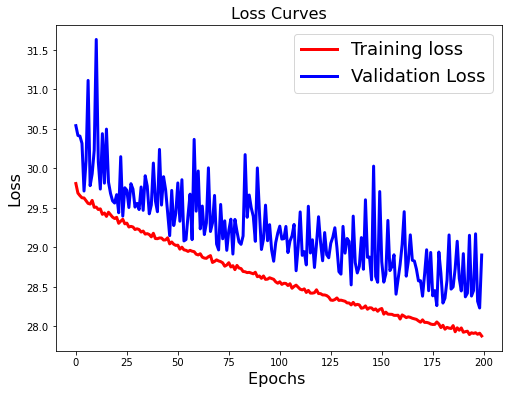

In [14]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 

In [15]:
recoY = my_network.predict(testX)

print('shape recoY = ', recoY.shape, '   shape testY = ', testY.shape)

dY = recoY - testY
dY0 = recoY[:,0] - testY[:,0]
dY1 = recoY[:,1] - testY[:,1]
dY2 = recoY[:,2] - testY[:,2]
dY3 = recoY[:,3] - testY[:,3]
dR = np.sqrt((recoY[:,0] - testY[:,0])*(recoY[:,0] - testY[:,0]) + (recoY[:,1] - testY[:,1])*(recoY[:,1] - testY[:,1]) + (recoY[:,2] - testY[:,2])*(recoY[:,2] - testY[:,2]) )
print(dR.shape, '  dR_mean = ', np.mean(dR))
R_true = np.sqrt(testY[:,0]*testY[:,0] + testY[:,1]*testY[:,1] + testY[:,2]*testY[:,2])
print(R_true.shape)
print(testY.shape)

print('dY: ',dY[0:3,:])
dRb = dR.reshape(dR.shape[0],1)
dY = dY/dRb
print('dY_norm: ',dY[0:3,:])
#np.random.shuffle(trueDir)
dYnoT = np.delete(dY,3,1) # CREATING a NEW dY1 VECTOR WITHOUT TIME COMPONENT 
vtx_dot_dir = np.sum(dYnoT*trueDir, axis=1)
print(vtx_dot_dir.shape)

shape recoY =  (29000, 4)    shape testY =  (29000, 4)
(29000,)   dR_mean =  9.893270191977077
(29000,)
(29000, 4)
dY:  [[ 3.5676386   8.8786761  -1.62006412  0.21957016]
 [ 9.01174917 -0.93932505 -5.09112991 -0.02952957]
 [ 6.30722249 -0.4854167  -0.91914632  0.20001984]]
dY_norm:  [[ 0.3676151   0.91487277 -0.16693396  0.02262486]
 [ 0.86710154 -0.09038092 -0.48986346 -0.00284131]
 [ 0.98669044 -0.07593771 -0.14378958  0.03129074]]
(29000,)


Text(0.5, 0, 'Dot product between Vtx(bias) and Dir(el)')

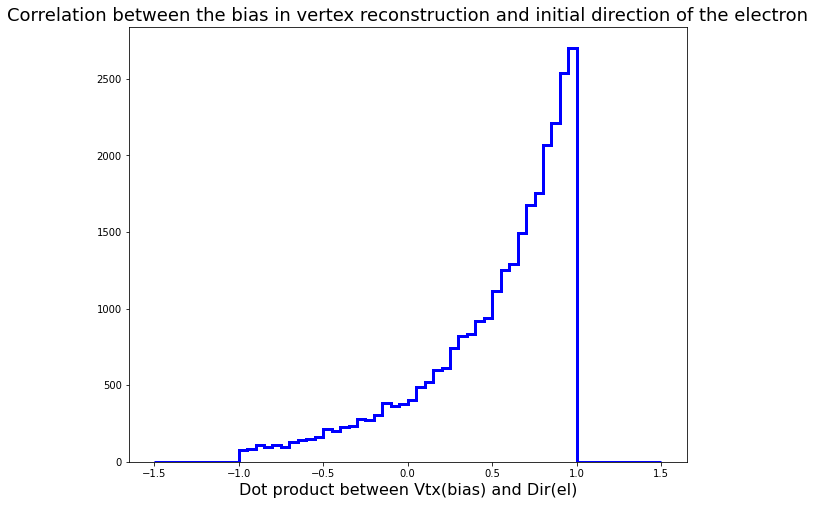

In [16]:
plt.figure(figsize=[10,8])
plt.hist(vtx_dot_dir, bins=60, range=(-1.5,1.5), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')
plt.title('Correlation between the bias in vertex reconstruction and initial direction of the electron', fontsize=18)
plt.xlabel('Dot product between Vtx(bias) and Dir(el)', fontsize=16)

MSE =  28.904902039859103
MSE2 =  28.904902039859103
dY0_Mean_vtx =  1.2778068700085978    dY1_Mean_vtx =  0.21879356620520063    dY2_Mean_vtx =  0.2951107610234468
dY0_Rms_vtx =  6.618221873969193     dY1_Rms_vtx =  6.320811656406926     dY2_Rms_vtx =  5.641408360532973
resolution_vtx =  10.750767835794116


dTime_Mean_ =  0.01859373875322013
dY3_Rms_vtx =  0.20149218419359938


Mean_true_vtx_0 =  -0.3076078315030439    Mean_true_vtx_1 =  0.5300797709649729 Mean_true_vtx_2 =  0.25814087370587274
RMS_true_vtx_0 =  134.3233354659404    RMS_true_vtx_1 =  133.72141350964563   RMS_true_vtx_2 =  134.32468871298255


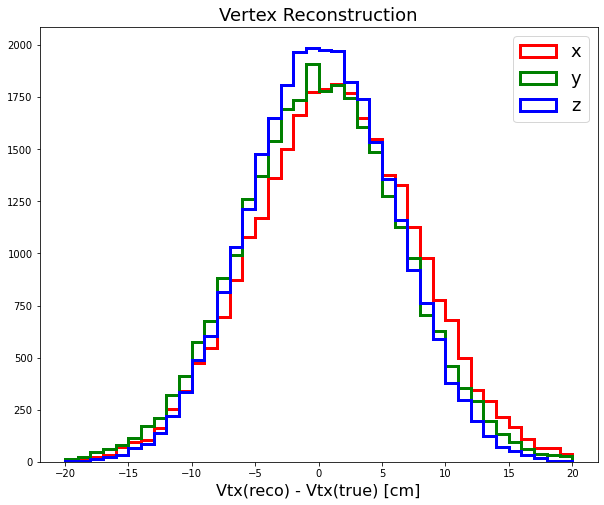

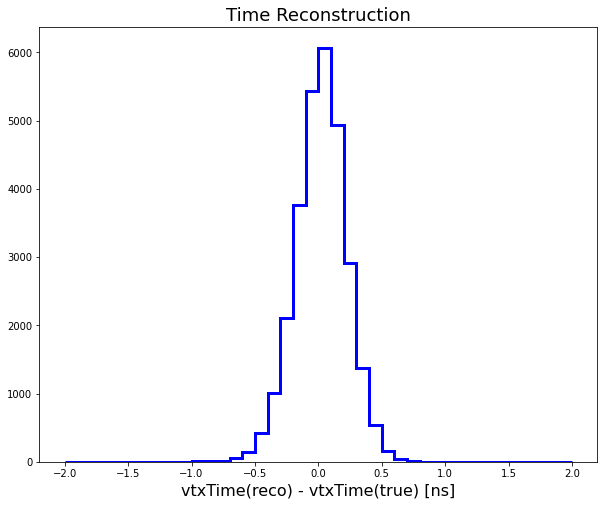

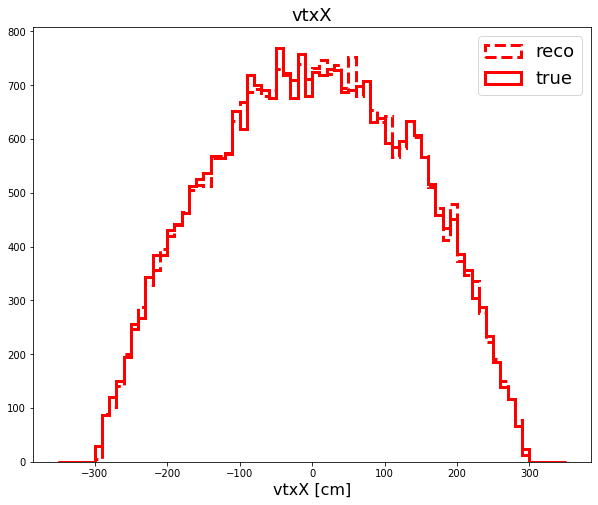

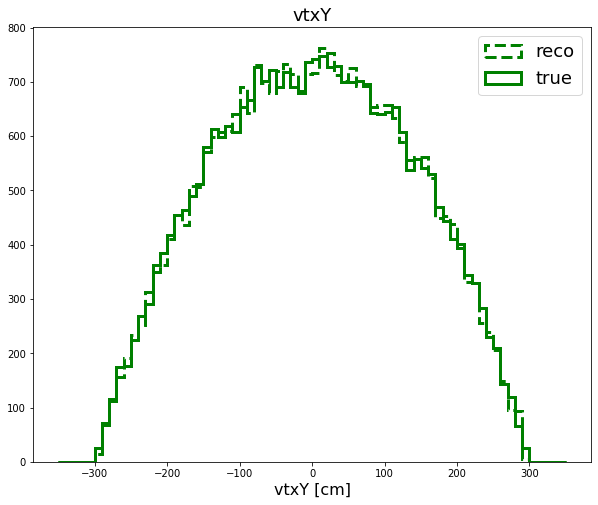

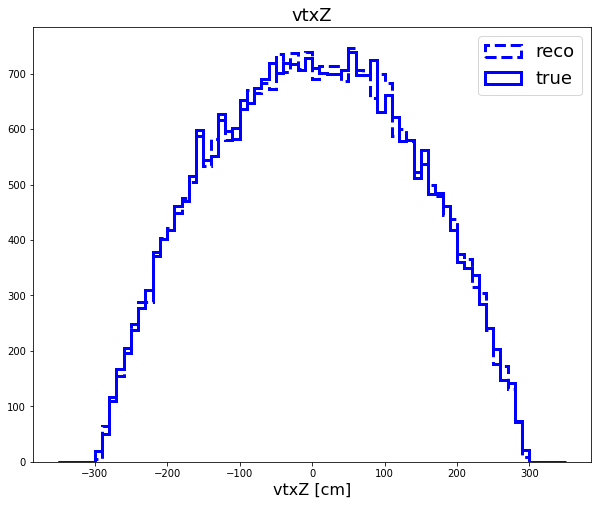

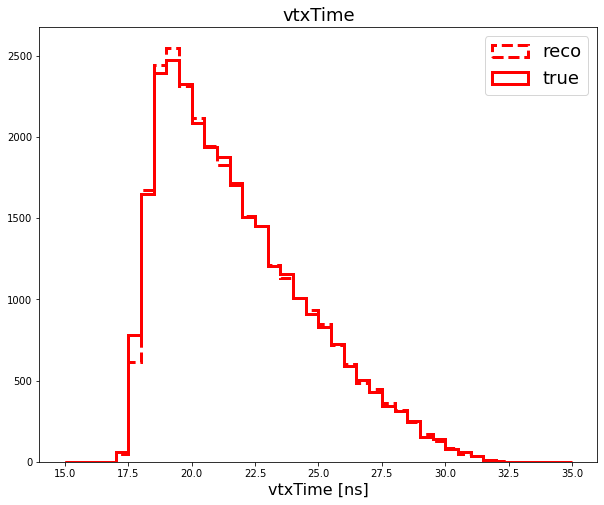

In [17]:
MSE = np.mean( (recoY.flatten()[:] - testY.flatten()[:])*(recoY.flatten()[:] - testY.flatten()[:]) )
print('MSE = ', MSE)

#MSE2 = np.mean(np.square(recoY - testY), axis=-1)
MSE2 = np.mean(np.square(recoY.flatten()[:] - testY.flatten()[:]), axis=-1)
print('MSE2 = ', MSE2)

#dTheta_dir = recoY[:,3] - testY[:,3]
#dPhi_dir = recoY[:,4] - testY[:,4]
print('dY0_Mean_vtx = ' ,np.mean(dY0), '   dY1_Mean_vtx = ', np.mean(dY1), '   dY2_Mean_vtx = ' ,np.mean(dY2))
print('dY0_Rms_vtx = ',np.sqrt(np.mean(np.square(dY0))), '    dY1_Rms_vtx = ',np.sqrt(np.mean(np.square(dY1))), '    dY2_Rms_vtx = ',np.sqrt(np.mean(np.square(dY2))))
print('resolution_vtx = ', np.sqrt(np.mean(np.square(dY0)) + np.mean(np.square(dY1)) + np.mean(np.square(dY2)) ) )
#print('ThetaMean_dir = ',np.mean(dTheta_dir),'   PhiMean_dir = ',np.mean(dPhi_dir))
#print('ThetaRms_dir = ',np.sqrt(np.mean(np.square(dTheta_dir))), '   PhiRms_dir = ',np.sqrt(np.mean(np.square(dPhi_dir))))

print('')
print('')

print('dTime_Mean_ = ' ,np.mean(dY3))
print('dY3_Rms_vtx = ',np.sqrt(np.mean(np.square(dY3))))

print('')
print('')


#fig_scatt = plt.figure()
#plt.scatter(R_true, dR)

fig_dYs = plt.figure(figsize=[10,8])
plt.hist(dY0, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')
plt.hist(dY1, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')
plt.hist(dY2, bins=40, range=(-20,20), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')
plt.legend(['x', 'y', 'z'],fontsize=18)
plt.title('Vertex Reconstruction',fontsize=18)
plt.xlabel('Vtx(reco) - Vtx(true) [cm]',fontsize=16)

fig_dT = plt.figure(figsize=[10,8])
plt.hist(dY3, bins=40, range=(-2,2), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')
plt.title('Time Reconstruction',fontsize=18)
plt.xlabel('vtxTime(reco) - vtxTime(true) [ns]',fontsize=16)


fig_Y0s = plt.figure(figsize=[10,8])
plt.hist(recoY[:,0], bins=70, range=(-350,350), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,0], bins=70, range=(-350,350), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')
plt.legend(['reco', 'true'],fontsize=18)
plt.title('vtxX',fontsize=18)
plt.xlabel('vtxX [cm]',fontsize=16)
fig_Y1s = plt.figure(figsize=[10,8])
plt.hist(recoY[:,1], bins=70, range=(-350,350), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'g')
plt.hist(testY[:,1], bins=70, range=(-350,350), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'g')
plt.legend(['reco', 'true'],fontsize=18)
plt.title('vtxY',fontsize=18)
plt.xlabel('vtxY [cm]',fontsize=16)
fig_Y2s = plt.figure(figsize=[10,8])
plt.hist(recoY[:,2], bins=70, range=(-350,350), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'b')
plt.hist(testY[:,2], bins=70, range=(-350,350), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'b')
plt.legend(['reco', 'true'],fontsize=18)
plt.title('vtxZ', fontsize=18)
plt.xlabel('vtxZ [cm]',fontsize=16)
fig_Y3s = plt.figure(figsize=[10,8])
plt.hist(recoY[:,3], bins=40, range=(15,35), histtype='step',ls='--', alpha = 1.0, lw=3, color= 'r')
plt.hist(testY[:,3], bins=40, range=(15,35), histtype='step',ls='solid', alpha = 1.0, lw=3, color= 'r')
plt.legend(['reco', 'true'],fontsize=18)
plt.title('vtxTime',fontsize=18)
plt.xlabel('vtxTime [ns]',fontsize=16)

print('Mean_true_vtx_0 = ', np.mean(testY[:,0]), '   Mean_true_vtx_1 = ' , np.mean(testY[:,1]), 'Mean_true_vtx_2 = ', np.mean(testY[:,2]))
print('RMS_true_vtx_0 = ' , np.sqrt(np.mean(np.square(testY[:,0]))), '   RMS_true_vtx_1 = ' , np.sqrt(np.mean(np.square(testY[:,1]))), '  RMS_true_vtx_2 = ', np.sqrt(np.mean(np.square(testY[:,2]))) )

In [ ]:
my_network.summary()